<a href="https://colab.research.google.com/github/sokrypton/algosb_2021/blob/main/alphafold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install a few things

In [1]:
%%bash
if [ ! -d af_backprop ]; then
  git clone https://github.com/sokrypton/af_backprop.git
  pip -q install biopython dm-haiku ml-collections py3Dmol
fi
if [ ! -d params ]; then
  mkdir params
  curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params
fi
wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py

Cloning into 'af_backprop'...


In [2]:
import sys
sys.path.append('/content/af_backprop')

import numpy as np
import matplotlib.pyplot as plt
import py3Dmol

import jax
import jax.numpy as jnp

from alphafold.common import protein
from alphafold.data import pipeline, templates
from alphafold.model import data, config, model, modules
from alphafold.common import residue_constants

from alphafold.model import all_atom
from alphafold.model import folding

# custom functions
from utils import *
import colabfold as cf

def plot_pdb(pdb_filename):
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  view.addModel(pdb_to_string(pdb_filename),'pdb')
  view.setStyle({'cartoon': {}})
  BB = ['C','O','N']
  view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                      {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})  
  view.zoomTo()
  view.show()


In [3]:
# setup which model params to use
model_name = "model_3_ptm"
model_config = config.model_config(model_name)

# number of recycles
model_config.model.num_recycle = 0
model_config.data.common.num_recycle = 0

# number of sequences
NUM = 512
model_config.data.common.max_extra_msa = 1
model_config.data.eval.max_msa_clusters = NUM
model_config.data.eval.masked_msa_replace_fraction = 0

# dropout
model_config = set_dropout(model_config, 0.0)

# setup model
model_params = [data.get_model_haiku_params(model_name=model_name, data_dir=".")]
model_runner = model.RunModel(model_config, model_params[0], is_training=True)

In [4]:
!wget -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0AG51.fas -O "RL30.a3m"

In [5]:
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open("RL30.a3m","r").readlines()))
query_sequence = msa[0]

In [6]:
np.random.seed(0)
idx = np.append(0,np.random.permutation(np.arange(1,len(msa))))[:NUM]
msa_ = [msa[i] for i in idx]
deletion_matrix_ = [deletion_matrix[i] for i in idx]

In [7]:
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence, description="none", num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa_],deletion_matrices=[deletion_matrix_]),
}
processed_feature_dict = model_runner.process_features(feature_dict, random_seed=0)
key = jax.random.PRNGKey(0)

In [8]:
outputs = model_runner.predict(processed_feature_dict)

In [9]:
outputs.keys()

dict_keys(['distogram', 'experimentally_resolved', 'masked_msa', 'predicted_aligned_error', 'predicted_lddt', 'structure_module', 'plddt', 'aligned_confidence_probs', 'max_predicted_aligned_error', 'ptm'])

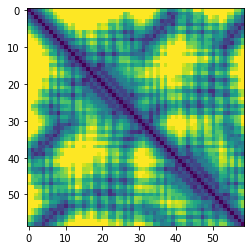

In [10]:
plt.imshow(outputs["distogram"]["logits"].argmax(-1))

In [11]:
save_pdb({"seq":feature_dict["aatype"],
          "outputs":outputs["structure_module"]},
         "tmp.pdb")

In [12]:
plot_pdb("tmp.pdb")

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
@jax.jit
def get_logits(inputs, i, a, mut_target=True):
  mut = jnp.eye(20)[a]
  if mut_target: inputs["target_feat"] = inputs["target_feat"].at[...,i,1:21].set(mut)
  inputs["msa_feat"] = inputs["msa_feat"].at[:,0,i,:20].set(mut).at[:,0,i,25:45].set(mut)

  key = jax.random.PRNGKey(0)
  outputs = model_runner.apply(model_params[0], key, inputs)
  return outputs["masked_msa"]["logits"][0,:,:20]

In [14]:
%%time
o_ = []
for i in range(len(query_sequence)):
  print(i)
  o_.append([])
  for a in range(20):
    o_[i].append(np.asarray(get_logits(processed_feature_dict,i,a)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
CPU times: user 14min 3s, sys: 9min 22s, total: 23min 26s
Wall time: 23min 18s


In [15]:
def o_to_contacts(o, center=True, symm=True):
  o_ = np.array(o)
  o_ -= np.array(o).mean((0,1))
  if symm:
    o_ = (o_ + o_.transpose((2,3,0,1)))/2
  if center:
    for i in range(4): o_ -= o_.mean(i,keepdims=True)

  #get contacts
  raw = np.sqrt(np.square(o_).sum((1,3)))
  np.fill_diagonal(raw,0)
  apc = raw - raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True) / raw.sum()
  np.fill_diagonal(apc,0)
  return raw, apc

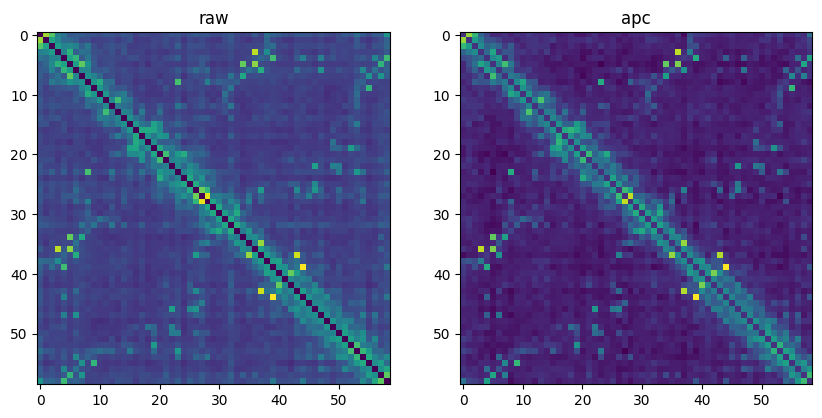

In [16]:
plt.figure(figsize=(10,5),dpi=100)
plt.subplot(1,2,1)
plt.title("raw")
plt.imshow(o_to_contacts(o_)[0])
plt.subplot(1,2,2)
plt.title("apc")
plt.imshow(o_to_contacts(o_)[1])
plt.show()

Peturb MSA experiments

In [12]:
def get_contacts(preds, seq_sep=6):
  less_8 = np.append(0,preds["distogram"]["bin_edges"]) < 8
  contacts = np.array(jax.nn.softmax(preds["distogram"]["logits"])[:,:,less_8].sum(-1))
  i,j = np.triu_indices_from(contacts,seq_sep)
  contacts_ = np.zeros_like(contacts)
  contacts_[i,j] = contacts[i,j]
  return contacts_ + contacts_.T

In [7]:
!wget -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0AG55.fas
msa, deletion_matrix = pipeline.parsers.parse_a3m("".join(open("P0AG55.fas","r").readlines()))

top = NUM
query_sequence = msa[0]
msa_np = np.array([list(s) for s in msa])
seq_id = np.array(msa_np[0] == msa_np).mean(-1)
idx = seq_id.argsort()[::-1][:top]
msa_top = [msa[i] for i in idx]
deletion_matrix_top = [deletion_matrix[i] for i in idx]

In [8]:
msa_ = [m[::-1] for m in msa_top]
deletion_matrix_ = [m[::-1] for m in deletion_matrix_top]
query_sequence = msa_[0]
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa_],deletion_matrices=[deletion_matrix_]),
}
processed_feature_dict = model_runner.process_features(feature_dict, random_seed=0)
preds = model_runner.predict(processed_feature_dict)

([], <a list of 0 Text major ticklabel objects>)

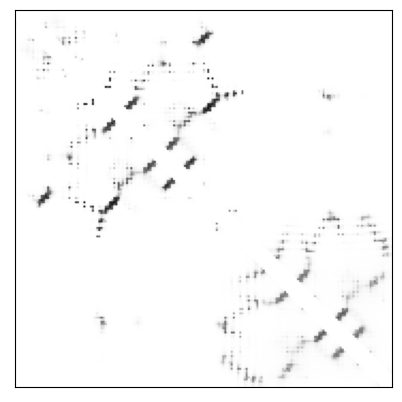

In [13]:
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(get_contacts(preds),cmap="Greys",vmin=0,vmax=1)
plt.xticks([]);plt.yticks([])

In [14]:
msa_ = [msa_top[0] for m in msa_top]
deletion_matrix_ = [deletion_matrix_top[0] for m in deletion_matrix_top]
query_sequence = msa_[0]
feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa_],deletion_matrices=[deletion_matrix_]),
}
processed_feature_dict = model_runner.process_features(feature_dict, random_seed=0)
preds = model_runner.predict(processed_feature_dict)

([], <a list of 0 Text major ticklabel objects>)

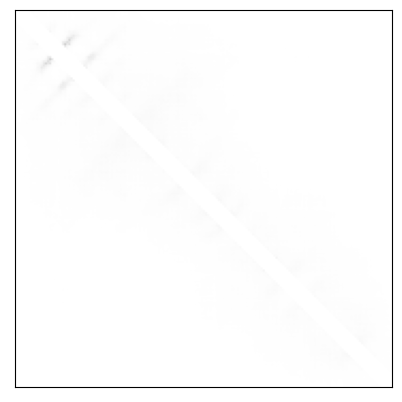

In [15]:
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(get_contacts(preds),cmap="Greys",vmin=0,vmax=1)
plt.xticks([]);plt.yticks([])

In [16]:
msa_top_np = np.array([list(s) for s in msa_top])
deletion_matrix_top_np = np.array(deletion_matrix_top)

for j in range(msa_top_np.shape[1]):
  msa_top_np[1:,j] = np.random.permutation(msa_top_np[1:,j])
  deletion_matrix_top_np[1:,j] = np.random.permutation(deletion_matrix_top_np[1:,j])

msa_ = ["".join(m) for m in msa_top_np]
deletion_matrix_ = [list(m) for m in deletion_matrix_top_np]

feature_dict = {
    **pipeline.make_sequence_features(sequence=query_sequence,
                                      description="none",
                                      num_res=len(query_sequence)),
    **pipeline.make_msa_features(msas=[msa_],deletion_matrices=[deletion_matrix_]),
}

processed_feature_dict = model_runner.process_features(feature_dict, random_seed=0)
preds = model_runner.predict(processed_feature_dict)

([], <a list of 0 Text major ticklabel objects>)

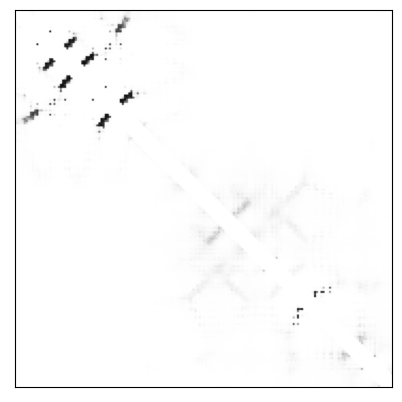

In [17]:
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(get_contacts(preds),cmap="Greys",vmin=0,vmax=1)
plt.xticks([]);plt.yticks([])

In [19]:
msa_top_np = np.array([list(s) for s in msa_top])
deletion_matrix_top_np = np.array(deletion_matrix_top)
contacts_permute = []
for k in range(100):
  print(k)

  # permute MSA
  permute_idx = np.random.permutation(np.arange(msa_top_np.shape[1]))
  unpermute_idx = permute_idx.argsort()
  msa_top_np_permute = msa_top_np[:,permute_idx]
  deletion_matrix_top_np_permute = deletion_matrix_top_np[:,permute_idx]

  ########################################
  msa_ = ["".join(m) for m in msa_top_np_permute]
  deletion_matrix_ = [list(m) for m in deletion_matrix_top_np_permute]

  feature_dict = {
      **pipeline.make_sequence_features(sequence=query_sequence,
                                        description="none",
                                        num_res=len(query_sequence)),
      **pipeline.make_msa_features(msas=[msa_],deletion_matrices=[deletion_matrix_]),
  }

  processed_feature_dict = model_runner.process_features(feature_dict, random_seed=0)
  preds = model_runner.predict(processed_feature_dict)
  contacts = get_contacts(preds)

  # unpermute CONTACTS
  contacts_permute.append(contacts[unpermute_idx,:][:,unpermute_idx])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [20]:
raw = np.mean(contacts_permute, 0)
apc = raw - (raw.sum(0,keepdims=True) * raw.sum(1,keepdims=True)) / raw.sum()

([], <a list of 0 Text major ticklabel objects>)

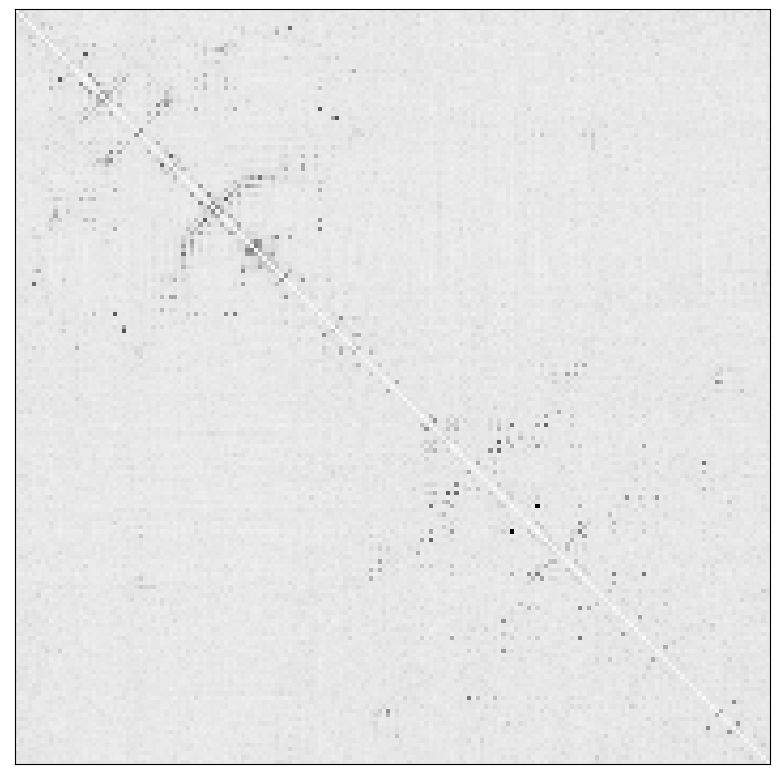

In [21]:
plt.figure(figsize=(10,10),dpi=100)
plt.imshow(apc, cmap="Greys") #,vmin=0 ,vmax=1)
plt.xticks([]);plt.yticks([])